In [1]:
library (dplyr)
library (tidyverse)
library (reshape2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following obj

In [2]:

path_data = ''

data <- read.delim(paste0(path_data, 'meta_for_enrichment.tsv'), header = TRUE)
Ref <- read.delim(paste0(path_data, 'control_for_enrichment.tsv'), header = TRUE)
head(Ref)


,line_morphogen,medium,cell_line,fullname_v5,morphogen_full,medium_morphogen,Control,Ctrl_short
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,H1_Ctrl_NIM,NIM,H1,Telencephalic Progenitors,Ctrl,Ctrl_NIM,H1_Ctrl_NIM,Ctrl_NIM
2,H9_Ctrl_NIM,NIM,H9,Telencephalic Progenitors,Ctrl,Ctrl_NIM,H9_Ctrl_NIM,Ctrl_NIM
3,H1_SHH_A_NIM,NIM,H1,Telencephalic Progenitors,SHH_A,SHH_A_NIM,H1_Ctrl_NIM,Ctrl_NIM
4,H9_SHH_A_NIM,NIM,H9,Telencephalic Progenitors,SHH_A,SHH_A_NIM,H9_Ctrl_NIM,Ctrl_NIM
5,H9_SHH_E_NIM,NIM,H9,CNS Neurons,SHH_E,SHH_E_NIM,H9_Ctrl_NIM,Ctrl_NIM
6,H1_SHH_E_NIM,NIM,H1,Hypothalamic Progenitors,SHH_E,SHH_E_NIM,H1_Ctrl_NIM,Ctrl_NIM


In [3]:
enrichment <- Reduce (rbind, 
                      pbapply::pblapply (which (Ref$line_morphogen != Ref$Control), function(x){          # pblapply is like lapply (apply and give list as output) but gives you a progress bar
  
  Experiment <- Ref$line_morphogen[x]        # Set "Experiment", "Control", "Condition" and "Cell_Line" 
  Control <- Ref$Control[x]              # from the values in the current row of the reference table
  Condition <- Ref$medium_morphogen[x]          
  Cell_Line <- Ref$cell_line[x]          # IF THIS LINE IS ACTIVE, WE ARE CALCULATING ENRICHMENT SEPARATELY FOR EACH LINE
  Ctrl_short <- Ref$Ctrl_short[x]   
  #print(Ctrl_short)
  # Here we select the rows from OSMGT that correspond to the current condition
  Idx <- which (data$line_morphogen == Experiment| data$line_morphogen == Control)
  
  
  # Here we create a frequency table for the number of cells in each cluster per Condition and corresponding Control
  freq <- table (data$fullname_v5[Idx], data$medium_morphogen[Idx]) %>%
    as.data.frame() %>%
    spread (Var2, Freq) %>%
    select (Condition, Ctrl_short, "Var1")
  
  # Here we use Reduce to rbind all the iterations of lapply by cluster (there is one fisher test per cluster in each Condition)
  res <- Reduce (rbind, lapply (1:nrow(freq), function(i) {
    # Generating one matrix per cluster (row)
    mat <- matrix (c (freq[i,1], 
                      freq[i,2], 
                      colSums (freq[,-3]) - c(freq[i,1],freq[i,2])), # This is a vector that gives 2 columns in the matrix
                   c(2,2))                                           # This sets the format of the matrix to 2x2
    # Running the Fisher test on the 2x2 matrix containing the number of cells in and out of each condition to compare (Condition vs Control)
    test <- fisher.test(mat)
    # Create a dataframe with all information about the Condition and cluster tested
    res <- data.frame (Experiment = Experiment,
                       Control = Control,
                       Condition = Condition,
                       Line = Cell_Line,
                       Cluster = freq$Var1[i],
                       oddsratio = unname(test$estimate),       # The unname function removes the name of the test estimate
                       pval = unname(test$p.value))
  }))
  # Now we return the Fisher results by Condition 
  # Each of these dataframes will be subject to rbind at the top of the function to generate a dataframe for all Conditions and clusters
  return(res)
}))


Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(Condition)

  # Now:
  data %>% select(all_of(Condition))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(Ctrl_short)

  # Now:
  data %>% select(all_of(Ctrl_short))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


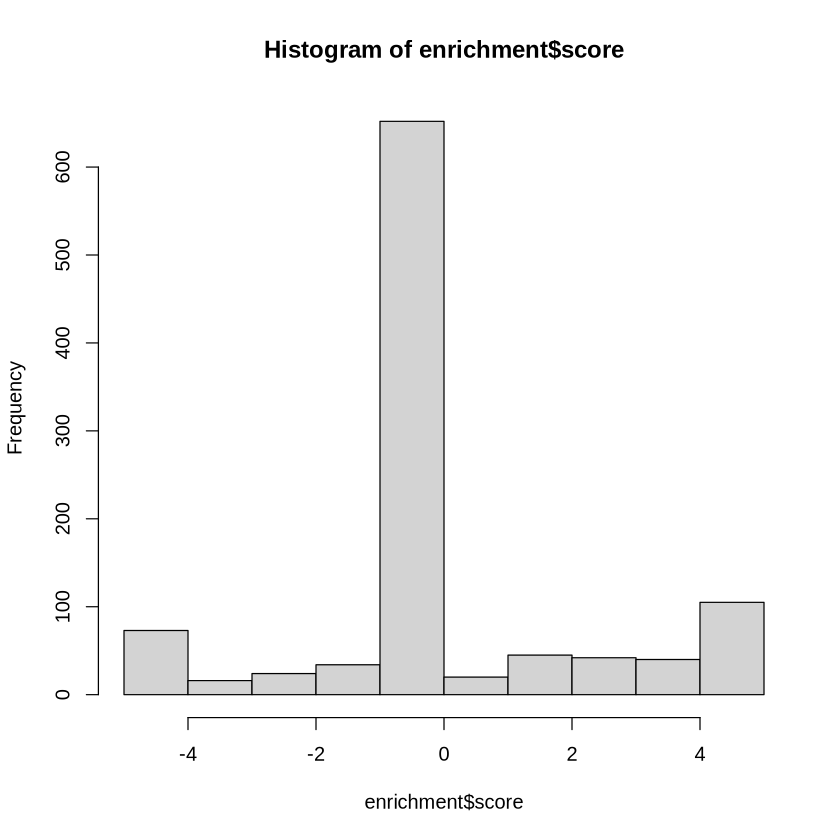

In [5]:
enrichment$padj <- p.adjust (enrichment$pval, method = "BH")

# Calculating LOG-ODDS-RATIO, a score that blends the p-value and odds ratio information
enrichment$score <- ifelse (enrichment$padj < 0.01,       # Condition to test (if adjusted p-value is lower than 0.01)
                            log2 (enrichment$oddsratio),  # YES --> calculate the log odds ratio (negative if odds ratio is smaller than 1, meaning there's less cells than in control)
                            0)                            # NO --> set it to 0 (no enrichment nor depletion)

# When the score's absolute value is bigger than the cap value, set it to the cap value with the sign of the score 
# The sign function returns 1 for + values and -1 for - values
# First of all we set a number as maximum score to be displayed
cap <- 5
enrichment$score [abs(enrichment$score) > cap] <- sign (enrichment$score [abs(enrichment$score) > cap]) * cap 
hist (enrichment$score)

# Plot with ggalign ED Fig. 9b

In [16]:
cols_grad <- c("#4D0066", "#64207A", "#7A408D", "#9060A0", "#A780B3", "#BDA0C6", "#D6C4DC", "#E3D6E7", "#F1EBF3", # Purple (depletion)
               "#EEEEEE",
               "#FFEEE0", "#FFDDC0", "#FFCCA0", "#FFBB80", "#FFAA60", "#FF9940", "#FF8820", "#FA7D10", "#F57200")

In [27]:
write.table(enrichment, '/links/groups/treutlein/USERS/nazbukina/fatima_revision/data/enrichment_parse.tsv', sep='\t')

[1] "SHH_A_NIM"       "SHH_E_NIM"       "RA_A_NIM"        "RA_E_NIM"       
 [5] "CHIR_A_NIM"      "CHIR_E_NIM"      "FGF8_late_A_NIM" "FGF8_late_E_NIM"
 [9] "CHIR_tA_NIM"     "CHIR_tC_NIM"     "CHIR_tE_NIM"     "SHH_A_NPM"      
[13] "SHH_E_NPM"       "RA_A_NPM"        "RA_E_NPM"        "CHIR_A_NPM"     
[17] "CHIR_E_NPM"      "FGF8_late_A_NPM" "FGF8_late_E_NPM" "CHIR_tA_NPM"    
[21] "CHIR_tC_NPM"     "CHIR_tE_NPM"

In [179]:
library(ggalign)
library(crthemes)
library(ggthemr)
path_fig = ''

In [288]:
cell = 'H9' # change for each cell line

pivot_df = enrichment[enrichment$Line == cell,]

pivot_df <- pivot_df %>% select(c('Condition', 'Cluster','score'))  %>%
  
            pivot_wider(

          
          names_from = 'Cluster',
         
          values_from = 'score',
          values_fill = 0.0,
         
        )
pivot_df <- as.data.frame(pivot_df)
rownames(pivot_df) <- pivot_df$Condition

pivot_df['Ctrl_NIM', ] = rep(0, ncol(pivot_df))
pivot_df['Ctrl_NPM', ] = rep(0, ncol(pivot_df))

order_cond = c('Ctrl_NIM',
'SHH_A_NIM','SHH_E_NIM','RA_A_NIM','RA_E_NIM','CHIR_A_NIM','CHIR_E_NIM','FGF8_late_A_NIM','FGF8_late_E_NIM',
              'CHIR_tA_NIM','CHIR_tC_NIM','CHIR_tE_NIM',
              'Ctrl_NPM','SHH_A_NPM','SHH_E_NPM',
            'RA_A_NPM','RA_E_NPM','CHIR_A_NPM','CHIR_E_NPM','FGF8_late_A_NPM',
              'FGF8_late_E_NPM','CHIR_tA_NPM','CHIR_tC_NPM','CHIR_tE_NPM')

cell_type_order = c('Telencephalic Progenitors', 'Retinal Progenitors',
'Cortical Hem/Diencephalon',   'Hypothalamic Progenitors',
  'Midbrain Progenitors','Floor Plate',
  'Hindbrain Progenitors', 'Spinal Cord Progenitors',
  'PNS Neurons','Neuroectoderm/Neuroepithelium', 'CNS Neurons',
  'Non-neurectodermal tissues','Neural Crest')
  

pivot_df = pivot_df[rev(order_cond),cell_type_order]   
pivot_df$Condition <- NULL
#pivot_df

In [289]:
ncell = data[data['cell_line'] == cell, ]

barplot_data <- ncell %>%
  count(medium_morphogen) %>%
  mutate(
    log_n = round(log10(n),1)  # Create a new column with the log10-transformed counts
  )



barplot_data <- barplot_data %>%
  mutate(
    medium_morphogen = factor(
      medium_morphogen,
      levels = rev(order_cond) 
    )
  )

barplot <- ggplot(barplot_data, aes(x = log_n, y = medium_morphogen)) +
  geom_col(fill = "#595959") +
  labs(
    x = "Number of Entries",
    y = NULL  # Remove y-axis label to align better
  ) +
  
  scale_x_reverse(breaks=c(max(barplot_data$log_n), 3,2, 0), expand = c(0, 0),
                 limits = c(max(barplot_data$log_n), 0),position = "top") +
  theme_rangeframe() + 

    coord_cartesian( xlim = c(max(barplot_data$log_n), 0))+ # to stop line from extending
      theme(
    axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
    axis.line.y = element_blank(),
    axis.title.y = element_blank(),
    strip.text = element_blank(),
      
      panel.border = element_blank(), 
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
      axis.line.x= element_line(color="black", size = 0.5),
          text = element_text(family = "sans"),
    axis.title = element_text(family = "sans"),
    axis.text = element_text(family = "sans"),
    legend.text = element_text(family = "sans"),
    plot.title = element_text(family = "sans")
  )



In [290]:
cell_type_colors <- list(
  'Telencephalic Progenitors' = '#e0762f',
  'Spinal Cord Progenitors' = '#a66d9b',
  'Hindbrain Progenitors' = '#e78e97',
  'Neuroectoderm/Neuroepithelium' = '#f4c617',
  'Hypothalamic Progenitors' = '#e83d63',
  'CNS Neurons' = '#3a5a89',
  'Cortical Hem/Diencephalon' = '#7A0000',
  'PNS Neurons' = '#2983aa',
  'Floor Plate' = '#8d4c88',
  'Midbrain Progenitors' = '#30d8c8',
  'Retinal Progenitors' = '#ac383f',
  'Mesenchyme' = '#92c051',
  'Neural Crest' = '#474a82',
  'Extraembryonic Tissue' = '#A5BC7B',
  'Endoderm/mesoderm-derived tissues' = '#67BD1B',
  'Non-neurectodermal tissues' = '#92c051',
  'Hindbrain_NPM?' = '#f3c2c7'
)


data_percentage <- ncell %>%
  group_by(medium_morphogen, fullname_v5) %>%
  summarise(count = n(), .groups = "drop") %>%
  group_by(medium_morphogen) %>%
  mutate(percentage = count / sum(count) * 100)

data_percentage$fullname_v5 <- factor(data_percentage$fullname_v5, 
                                      levels = rev(c(cell_type_order)))
                                          
data_percentage <- data_percentage %>%
  mutate(
    medium_morphogen = factor(
      medium_morphogen,
      levels = rev(order_cond) 
    )
  )
# Create the stacked barplot
stacked_barplot <- ggplot(data_percentage, aes(y = medium_morphogen, x = percentage, fill = fullname_v5)) +
  geom_bar(stat = "identity") +  # Use identity because percentages are precomputed

  scale_fill_manual(values = cell_type_colors)+
  labs(
    y = NULL,
    x = NULL,
    fill = NULL,
    title = NULL
  ) +
  
  scale_x_continuous(breaks=c(0, 25,50,75,100), expand = c(0, 0),position = "top") +
  theme_rangeframe() + 

    coord_cartesian( xlim = c(0, 100))+ # to stop line from extending
      theme(
    axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
    axis.line.y = element_blank(),
    axis.title.y = element_blank(),
    strip.text = element_blank(),
      
      panel.border = element_blank(), 
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
      axis.line.x= element_line(color="black", size = 0.5),
          legend.position = "none" ,
        
    text = element_text(family = "sans"),
    axis.title = element_text(family = "sans"),
    axis.text = element_text(family = "sans"),
    legend.text = element_text(family = "sans"),
    plot.title = element_text(family = "sans")
  )



In [291]:
#options(repr.plot.width=15, repr.plot.height=8)


setwd(path_fig)
pdf(paste0(cell,".pdf"),width=15,height=8)


ggheatmap(pivot_df) + scale_fill_gradientn(colors=c(cols_grad)) + 
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_blank(),
        axis.ticks.y = element_blank()# Rotate labels 45 degrees
  )+
  anno_left(size=0.5) + ggfree()+barplot +
  anno_right(size=2) + ggfree() + stacked_barplot

dev.off()

ggsave(paste0(path_fig, "H9.pdf"), # change names for each cell line
       #width=15, height=8



→ heatmap built with `geom_tile()`


png 
  2